In [1]:
import cv2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.path import Path
import dicom
import os
%matplotlib inline

### Open one training image

In [3]:
folder_path = './Data/challenge_training/SC-HF-I-1/'

In [4]:
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(folder_path):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))

In [5]:
# Get ref file
RefDs = dicom.read_file(lstFilesDCM[0])

# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))

# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

In [6]:
x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

In [7]:
# The array is sized based on 'ConstPixelDims'
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# loop through all the DICOM files
# all files need to have the same shape
for filenameDCM in lstFilesDCM[:9]:
    # read the file
    ds = dicom.read_file(filenameDCM)
    # store the raw image data
    ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array  

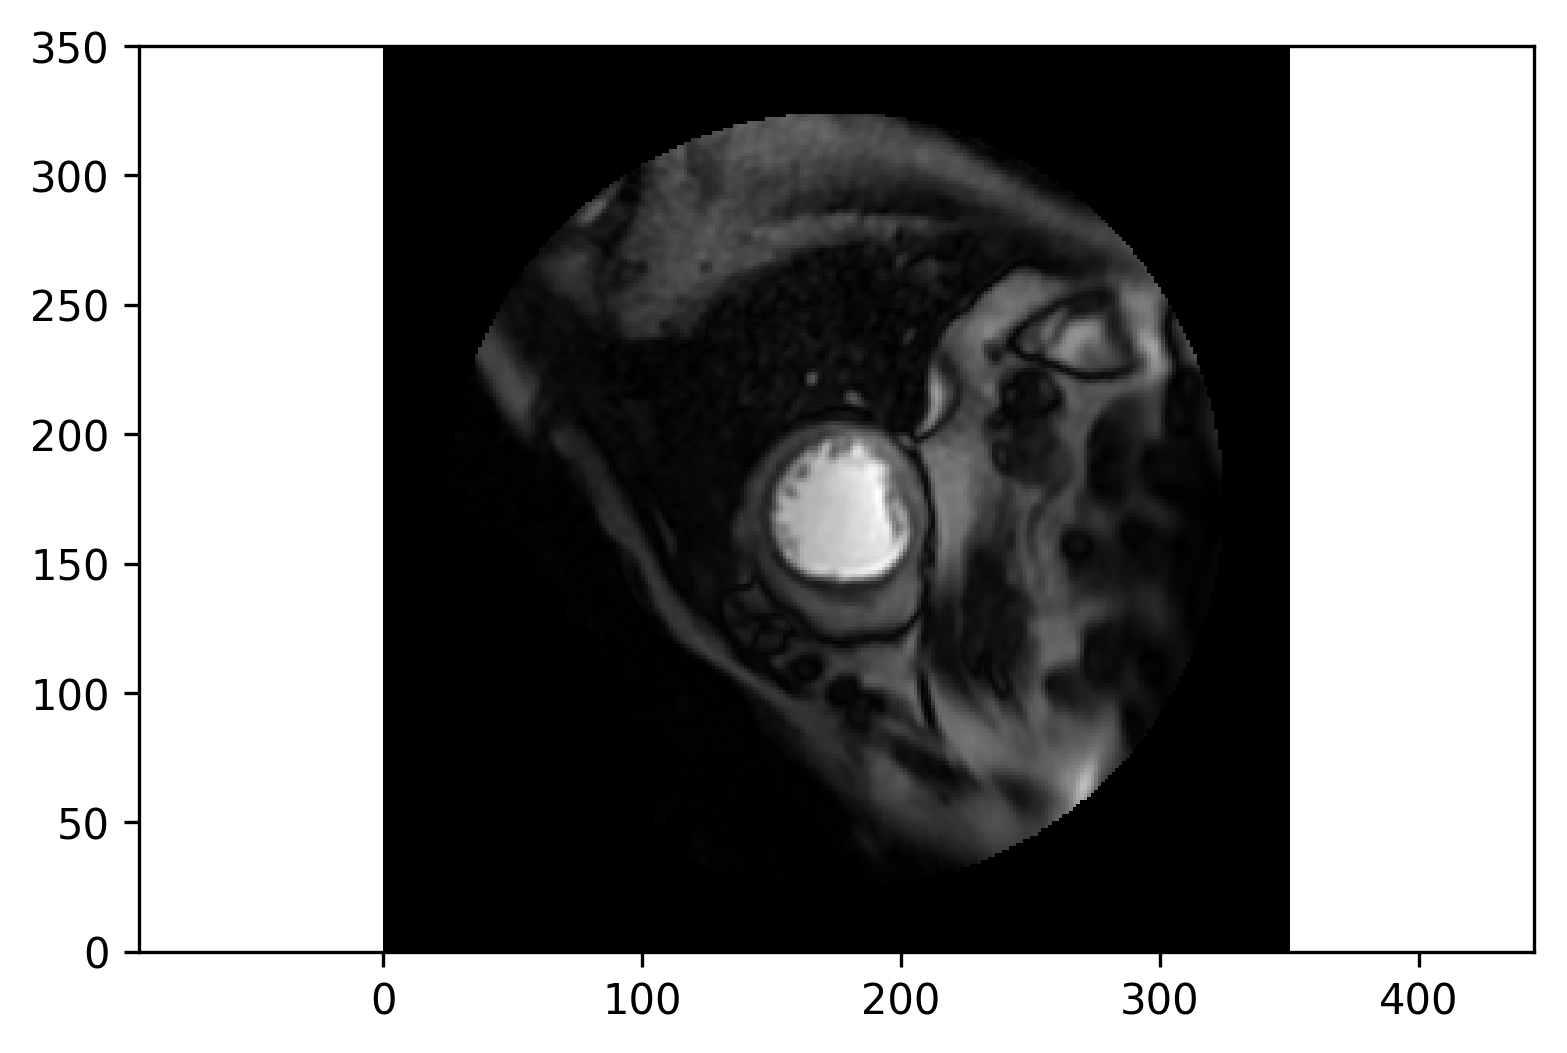

In [8]:
plt.figure(dpi=300)
plt.axes().set_aspect('equal', 'datalim')
plt.set_cmap(plt.gray())
plt.pcolormesh(x, y, np.flipud(ArrayDicom[:, :, 8]))

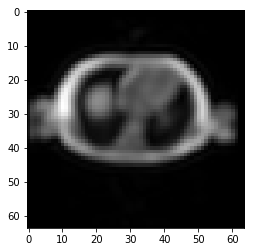

In [24]:
image_part = dicom.read_file('./Data/challenge_training/\
SC-HF-I-1/IM-0002-0048.dcm').pixel_array  
plt.imshow(image_part)

### Open one training contour

In [2]:
import glob
folder_text_path = './Data/Sunnybrook Cardiac MR Database ContoursPart3/\
TrainingDataContours/SC-HF-I-01/contours-manual/IRCCI-expert/'
text_arr = glob.glob(folder_text_path + '*')

In [3]:
text_path = './Data/Sunnybrook Cardiac MR Database ContoursPart3/\
TrainingDataContours/SC-HF-I-01/contours-manual/IRCCI-expert/\
IM-0001-0048-icontour-manual.txt'

In [4]:
n = 59
pic_arr = [k for k in glob.glob("./Data/challenge_training/SC-HF-I-1/" + '*') if '00' + str(n) in k]
text_path = './Data/Sunnybrook Cardiac MR Database ContoursPart3/\
TrainingDataContours/SC-HF-I-01/contours-manual/IRCCI-expert/\
IM-0001-00%s-icontour-manual.txt' % str(n)

In [5]:
for pic_path in pic_arr:
    contour = []
    file = open(text_path, 'r') 
    for line in file: 
        contour.append(tuple(map(float, line.split())))
    contour = np.array(contour)

    image_part = dicom.read_file(pic_path).pixel_array  
    plt.figure(figsize=(10,10))
    plt.imshow(image_part)
    plt.imshow(image_part)
    plt.plot(*zip(*contour), )
    plt.show()
    input('Enter for next')

### Plot ROI from contour

In [6]:
import matplotlib.patches as patches

In [10]:
case = 'SC-HF-NI-36'
series = {'SC-N-40' : '0944',
          'SC-N-03' : '0915',
          'SC-N-02' : '0898',
          'SC-HYP-40' : '0755',
          'SC-HYP-38' : '0734',
          'SC-HYP-03' : '0650',
          'SC-HYP-01' : '0550',
          'SC-HF-NI-36' : '0474',
          'SC-HF-NI-34' : '0446',
          'SC-HF-NI-04' : '0501',
          'SC-HF-NI-03' : '0379',
          'SC-HF-I-40' : '0134',
          'SC-HF-I-04' : '0116',
          'SC-HF-I-02' : '0106',
          'SC-HF-I-01' : '0004'}
image_path_base = './Data/challenge_training/%s/IM-%s' % (case, series[case])
contour_path_base = './Data/Sunnybrook Cardiac MR Database ContoursPart3/\
TrainingDataContours/%s/contours-manual/IRCCI-expert/' % case
contours_list = glob.glob(contour_path_base + '*')
contours_list_series = [k.split('/')[7].split('-')[2] for k in contours_list]
contour_chosen = np.random.choice(contours_list_series)
idx_contour = contours_list_series.index(contour_chosen)
contour_path = contours_list[idx_contour]
image_path = image_path_base + '-%s.dcm' % contour_chosen

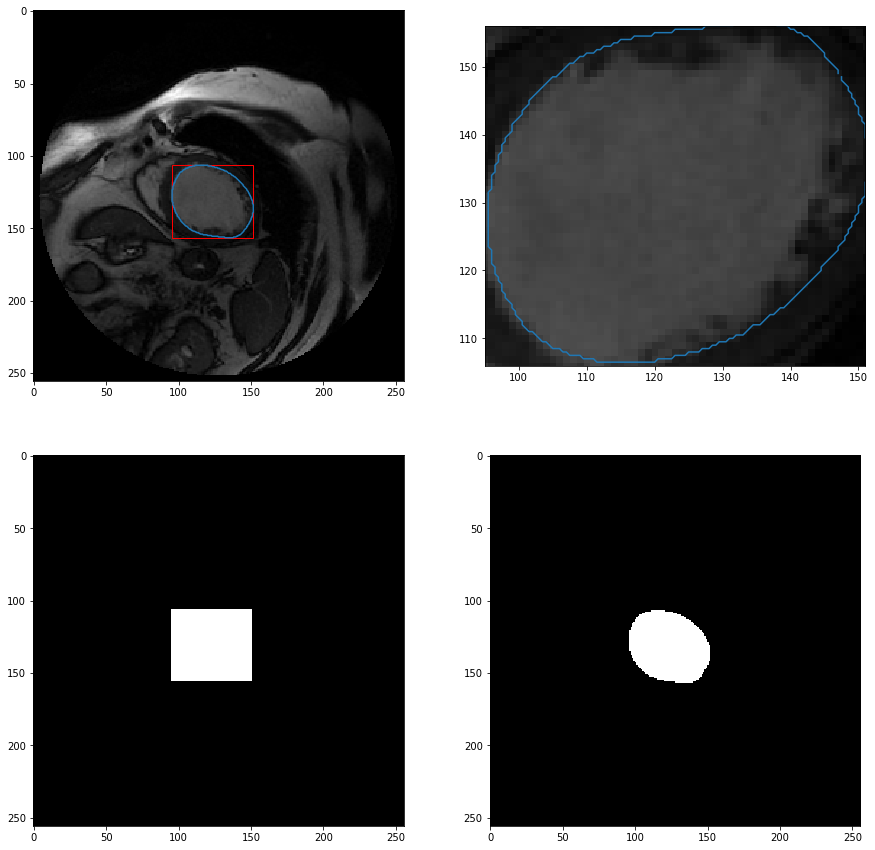

In [11]:
from matplotlib.path import Path
image_part = dicom.read_file(image_path).pixel_array  
contour = []
file = open(contour_path, 'r') 
for line in file: 
    contour.append(tuple(map(float, line.split())))
contour = np.array(contour)

# ROI = rectangle autour du contour
X_min, Y_min = contour[:,0].min(), contour[:,1].min()
X_max, Y_max = contour[:,0].max(), contour[:,1].max()
w = contour[:,0].max() - contour[:,0].min() 
h = contour[:,1].max() - contour[:,1].min()

# Mask
mask_roi = np.zeros(image_part.shape)
mask_roi[int(contour[:,1].min()):int(contour[:,1].max()), 
         int(contour[:,0].min()):int(contour[:,0].max())] = 1.0

x, y = np.meshgrid(np.arange(256), np.arange(256)) # make a canvas with coordinates
x, y = x.flatten(), y.flatten()
points = np.vstack((x,y)).T 
p = Path(contour) # make a polygon
grid = p.contains_points(points)
mask_contour = grid.reshape(256,256)
  
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax[0, 0].imshow(image_part, cmap='gray')
ax[0, 0].plot(*zip(*contour))
rect = patches.Rectangle(
        (X_min,Y_min),
        w, h,
        linewidth=1, edgecolor='r', facecolor='none')
ax[0, 0].add_patch(rect)

ax[1, 0].imshow(mask_roi, cmap='gray')
ax[1, 1].imshow(mask_contour*1, cmap='gray')
ax[0, 1].imshow(image_part, cmap='gray')
ax[0, 1].plot(*zip(*contour))
ax[0, 1].set_xlim(int(contour[:,0].min()), int(contour[:,0].max()))
t = ax[0, 1].set_ylim(int(contour[:,1].min()), int(contour[:,1].max()))